In [1]:
%matplotlib inline

In [2]:
import os
import glob
import json
import pandas as pd
import geopandas as gpd
import shapely
import shapely.geometry
import cv2 as cv
import affine
import rasterio
import rasterio.features
import numpy as np
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [3]:
ANN_IN_DIR = 'data/GiveDirectly/Mask'

In [4]:
files = glob.glob(os.path.join(ANN_IN_DIR, '*.json'))

In [5]:
output = []
for file in files:
    with open(file, 'r') as f:
        ann = json.load(f)
    img = cv.imread(file.replace('.json', '').replace('Mask', 'Image'))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    for ins in ann['objects']:
        poly = shapely.geometry.Polygon(ins['points']['exterior'])

        binary_mask = rasterio.features.geometry_mask(
            geometries=[poly],
            out_shape=img.shape[0:2],
            transform=affine.Affine.identity(),
            invert=True)

        # extract RGB mean from image
        R_mean, G_mean, B_mean = np.mean(img[binary_mask, :], axis=0)
        R_median, G_median, B_median = np.median(img[binary_mask, :], axis=0)

        output.append({
            'R_mean': R_mean,
            'G_mean': G_mean,
            'B_mean': B_mean,
            'R_median': R_median,
            'G_median': G_median,
            'B_median': B_median,
            'area': poly.area,
            'category': ins['classTitle'],
            'img_id': os.path.basename(file).split('.')[0],
        })

In [6]:
output = pd.DataFrame(output)

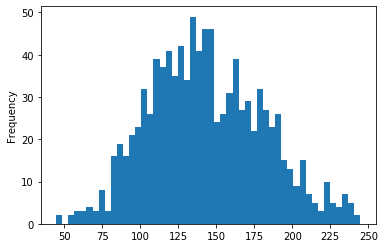

In [7]:
output['R_mean'].plot(kind='hist', bins=50)

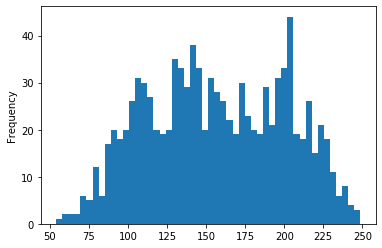

In [8]:
output['G_mean'].plot(kind='hist', bins=50)

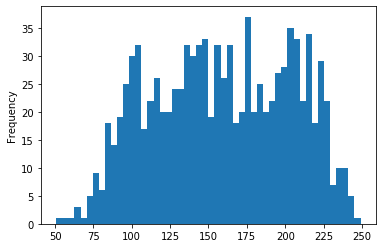

In [9]:
output['B_mean'].plot(kind='hist', bins=50)

In [10]:
output.replace(
    {'thatched roof': 0, 'metal roof': 1, 'colored roof': 2},
    inplace=True)

In [11]:
output = output.loc[output['category'] < 2, :]

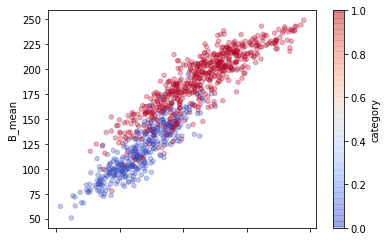

In [12]:
output.plot(x='R_mean', y='B_mean', c='category',
            kind='scatter', cmap='coolwarm', alpha=0.3)

In [13]:
X = output.loc[:, ['R_mean', 'G_mean', 'B_mean']].values
y = output.loc[:, 'category'].values

In [14]:
# other non linear kernels perform worse
# median perform worse

In [15]:
clf = svm.SVC(kernel='linear')
scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.89893617, 0.95187166, 0.88235294, 0.89839572, 0.85561497])

In [16]:
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [17]:
# the following is the same as clf.predict(X).astype(bool)
pred = ((X.dot(clf.coef_.T) + clf.intercept_) > 0).squeeze()

In [18]:
(pred == clf.predict(X).astype(bool)).all()

True

In [19]:
clf.intercept_

array([-6.17484352])

In [20]:
clf.coef_

array([[-0.06021201,  0.0905571 ,  0.00755191]])